In [1]:
%matplotlib inline
from pprint import pprint
from decimal import Decimal
import itertools
import metrics
import pandas

import simulate
import harvesting
import market
import withdrawal
import numpy

In [2]:
import seaborn
from matplotlib import pyplot as plt
import matplotlib
seaborn.set(style="whitegrid")
seaborn.set_context('poster')

In [3]:
series = market.Returns_US_1871()

In [4]:
def mk_lens(type_):
    m = {'Withdrawal (Nominal)': lambda x: float(x.withdraw_n),
         'Withdrawal (Real)' : lambda x: float(x.withdraw_r),
         'Portfolio (Nominal)': lambda x: float(x.portfolio_n),
         'Portfolio (Real)': lambda x: float(x.portfolio_r),
         'Bond %': lambda x: float(x.portfolio_pre.bonds / (x.portfolio_pre.bonds + x.portfolio_pre.stocks))
    }
    lens = m[type_]
    lens.__label__ = type_
    return lens

def fn(lens, x):
    return [lens(_) for _ in x]

In [5]:
def run_sim(year, key, length=35):
    h = {
        'tent': lambda p: harvesting.ParameterGlidepath(p, 0.4, 0.75, 30),
        'static-60': harvesting.make_rebalancer(0.60),
    }

    portfolio = (400_000, 600_000)
    
    return simulate.withdrawals(series.iter_from(year),
                                 withdraw=withdrawal.ConstantDollar,
                                 years=length,
                                 portfolio=portfolio,
                                 harvesting=h[key])

In [6]:
def cew_one(year):
    tent = run_sim(year, 'tent')
    static = run_sim(year, 'static-60')
    
    from lens import calc_coverage_ratio
    m_tent = calc_coverage_ratio(tent, 35)
    m_static = calc_coverage_ratio(static, 35)
    
    return {'tent': m_tent, 'static-60': m_static}
    

def cew_all():
    df = pandas.DataFrame(index=range(1887, 2019 - 30 + 1), columns=['tent', 'static-60'])
    for i in range(1887, 2019 - 30 + 1):
        r = cew_one(i)
        df.loc[i] = r
    return df

In [7]:
cew_one(1929)

/home/justus/Dropbox/jupyter/prime-harvesting/lens.py:38: FutureWarning: `item` has been deprecated and will be removed in a future version
  b_t = df.tail(1)['portfolio_post'].item().value_r


{'tent': Decimal('0.39093058888595836880773'),
 'static-60': Decimal('-3.664043789848058629994705617')}

In [8]:
%time
df = cew_all()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


In [9]:
df.head()

,tent,static-60
1887,-5.641685511292231342090832274,-5.571327756511728313650367943
1888,-3.692466840497680644562706011,-3.467850510694986037460207266
1889,-4.896053867969620742313977020,-4.471267276880196204148185580
1890,-5.354262364722899057626044846,-5.07973289582551263650240820
1891,-2.902318453647697000406517931,-2.236930272112184837343450434


20


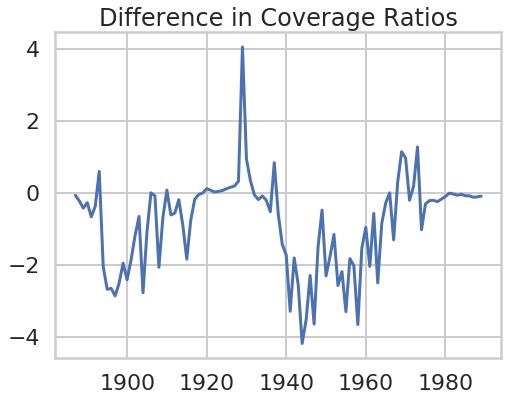

In [17]:
tent_wins = df[df['tent'] > df['static-60']]
print(len(tent_wins))
diff = df['tent'] - df['static-60']
plt.figure(figsize=(8,6))
plt.title('Difference in Coverage Ratios')
seaborn.lineplot(data=diff.astype(float))

In [11]:
diff[diff > 0]

1893     0.595821489691000878856227343
1910     0.075566854329544694991236677
1920         0.11616115315305117846239
1921         0.07152173342802914686777
1922         0.02119126478247701310134
1923         0.04081501651273901012175
1924         0.06522978188202897498717
1925         0.11621602084027493018214
1926         0.15507233263038660874670
1927         0.18759072792759220794450
1928         0.32279646206024727155010
1929     4.054974378734016998802435617
1930    0.9413219659665331584006542710
1931         0.33880329961607736452769
1937     0.838577009264029216213914277
1968      0.28571428571428553189193167
1969      1.14285714285714282145711706
1970     0.969842630715698702761513975
1972     0.183742653775111786804743421
1973     1.276802193303332857526385546
dtype: object

In [12]:
tent_wins['tent'] / tent_wins['static-60']

1893     0.6798374378846746350936617505
1910     0.9903834030185673630182266397
1920      1.083573126813368981668685493
1921      1.041498334552760101258619223
1922      1.014981948340201365478257125
1923      1.037970061118310053992263464
1924      1.050081187485027825609779931
1925      1.106137981353908042191483172
1926      1.164117379779019993592077418
1927      1.200831995088292141384967596
1928      1.815195372418555505540178092
1929    -0.1066937545804193470214196235
1930     -1.608053134846074451664683047
1931      2.010036602771191348569220999
1937     0.8945382940806370029965898020
1968     0.9767441860465116426178821542
1969     0.9069767441860465139921596324
1970     0.8414891724710293725387605356
1972     0.9758241513991106158072320792
1973     0.8667598948267620730680549361
dtype: object

In [13]:
def chart_one(year, lens):
    tent = run_sim(year, 'tent')
    static = run_sim(year, 'static-60')
    
    df = pandas.DataFrame({
        'tent' : fn(lens, tent),
        'static-60' : fn(lens, static),
    })
    g = seaborn.relplot(
            data=df,
            kind='line',
            aspect=2,
        )
    g.fig.autofmt_xdate()
    g.despine(left=True, bottom=True, offset=20)
    g.fig.suptitle(f'Retirement in {year}')
    return g

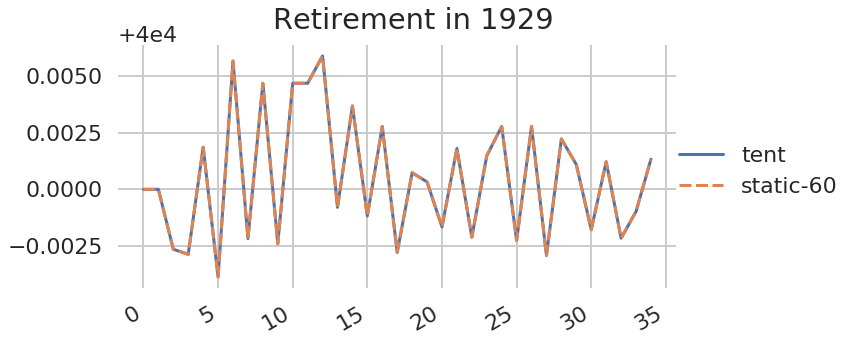

In [14]:
chart_one(1929, mk_lens('Withdrawal (Real)'))
#chart_one(1929, mk_lens('Bond %'))
s = df.loc[1929]

In [15]:
def one(year, lens):
    tent = run_sim(year, 'tent')
    static = run_sim(year, 'static-60')
    
    df = pandas.DataFrame({
        'tent' : fn(lens, tent),
        'static-60' : fn(lens, static),
    })
    return df

In [16]:
one(1929, mk_lens('Bond %')).head()

,tent,static-60
0,0.600000,0.4
1,0.588333,0.4
2,0.576667,0.4
3,0.565000,0.4
4,0.553333,0.4
